# THE STANFORDOPEN POLICINGPROJECT part 3

ต่อมาจาก part 2 จะเห็นว่าข้อมูลที่มีอยู่นั้น เป็น imbalance data คือ การตวรจค้นของตำรวจหลังจากยานพาหนะ ได้มีการเรียกให้หยุดโดยตำรวจ ไม่ได้มีจำนวนการเกิดขึ้นมากพอที่จะเทียบเท่ากับ การไม่ได้ตวรจค้นภายในยานพาหนะ พูดง่ายๆ ว่า ค้นภายในรถบางคันเท่านั้น รถที่ถูกเลือกที่ตรวจค้นจึงน้อยกว่ารถที่ไม่ถูกค้นเป็นจำนวนมาก

## จุดมุ่งหมายของการปรับปรุง Machine Learning model

1. จัดการ imbalace data ในที่นี้เลือกใช้แบบไหนต้องลองดูกันว่าแบบไหนดีที่สุดจาก Random undersampling, Ensamble resampling, Class re-weight แต่ขอข้ามตัวที่เพิ่มข้อมูลที่เป็นการใช้ perfomance ของคอมพิวเตอร์สูงไปก่อนคือตัว Random oversampling และ SMOT (Synthetic Minority Oversampling Technique)

2. ทดลองกับ machine learning โดยใช้หลักการ Multi-Fidelity Search ทั้ง grid serch และ random search

3. ใช้ hyperband ช่วยในการ allocate resource เป็นการช่วยให้สามารถทำงานบนเครื่องคอมพิวเตอร์ที่ไม่ได้มี resource สูงมาก และประหยัดเวลากว่า gridsearch และ randomsearch

4. เลือกดูค่าการวัดผลที่สอดคล้องกับการใช้งานจริงจาก coufusion matrix ในที่นี้้ต้องดูค่า recall จาก Precision-Recal Curve แล้วดูค่า Area under Precision-Recall Curve (AUC of PR-curve) and Average Precision (AP) ประกอบด้วย

### "Although we already reduced the space of considered ML algorithmssubstantially compared to our previous Auto-sklearn (4 vs. 15 classifiers), we could have reduced this set even further since, in the end, only XGBoost models ended up in the final ensembles for the challenge"

Feurer et al, PoSH auto-sklearn

จาก คำพูดข้างบนนี้ เราจึงไม่ได้ใช้ AUTO ML แต่เลือกที่จะใช้ XGBoost models หลังจากจัดการกับ imbalance data

[XGBoost Python Package](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)

# เริ่มสร้าง Machine learning model กันเลยครับ

  กำหนดตัวผลลัพท์จาก model ที่เราต้องการ
ขั้นแรก เราต้องการให้ผลลัพท์คือ ค่า y_pred (ค่าการทำนายจาก model) จากข้อมูลของการปฏิบัติงานของตำรวจใน Rhode Island ที่เกิดขึ้นจริงและเก็บ record ไว้ ในครั้งนี้จะมาสนใจในการทำ model ว่าจากพื้นฐานข้อมูลที่มีอยู่นี้ลักษณะการปฏิบัติงานของตำรวจส่งผลต่อการ ตรวจค้นยานพาหนะในท้ายที่สุดหรือไม่ นั่นก็คือ เราให้ label ที่ต้องการจะ model บอกเราครับ เพราะฉะนั้น จากตารางที่เรามีข้างล่างจะเห็นว่า ควร drop เรื่องของการถูกจับกุมหลังตรวจค้นยานพาหนะทิ้งไปเนื่องจากเป็นผลที่เกิดหลังจากพบเจอสิ่งผิดกฏหมาย
<br>
<br>
  <b><U>ให้ label หรือผลลัพธ์ที่ต้องการจาก model ที่ได้คือ search_conducted ก็คือการตรวจค้นยานพาหนะ<b><u>

## Importing the libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

## Importing the dataset and prepare prior to model input

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
raw = pd.read_csv('/content/drive/MyDrive/SWU MSDS Semester1/DS511 Data Science/ProjectFinalDS511_110_115/PoliceRI2020cleaned.csv',index_col= "date_stop_time")

In [0]:
raw.head()

## ทำการสลับให้ column ที่เป็น label ไปอยู่ท้ายสุดให้ง่ายต่อการเลือก column ในการทำงาน

ข้อมูลเป็นแบบตารางที่ทำการ clean มาเรียบร้อยแล้วแต่ยังต้องมีการจัดเรียงให้ง่ายต่อการป้อนเข้าสู่ model ของ ML: machine learning ต่อไป เราจะกำหนดจากจุดมุ่งหมายได้บน

In [0]:
raw.columns

In [0]:
raw = raw[['district', 'driver_race', 'driver_gender', 'arrest_made',
       'citation_issued', 'warning_issued', 'contraband_drugs',
       'contraband_weapons', 'contraband_alcohol', 'frisk_performed',
       'reason_for_stop', 'search_conducted']]
raw.head()

ต่อไป คือการทำการ drop column "arrest_made" ควร drop เรื่องของการถูกจับกุมหลังตรวจค้นยานพาหนะทิ้งไปเนื่องจากเป็นผลที่เกิดหลังจากพบเจอสิ่งผิดกฏหมายโดยใช้ code ดังนี้

In [0]:
raw.drop('arrest_made', axis=1, inplace= True)
raw.head()

### ทดลองดึงข้อมูลออกมาดูจากแถวที่ 25 โดยไม่รวมเอา column ที่เป็น Label (ผลลัพธ์) ออกมาด้วย ว่าข้อมูลมีลักษณะอย่างไร

In [0]:
raw.iloc[25, :-1].values

## ทำการแบ่งชุดข้อมูลให้เป็นส่วนของการ train ของ model และ ส่วน Label ของ model

### Splitting the dataset into the Training set and Test set

In [0]:
X = raw.iloc[:, :-1].values
y = raw.iloc[:, -1].values
print("X :", X)
print("y :", y)
print("X shape :", X.shape)

## Encoding the Independent Variable

### ขั้นตอนนี้เป็นการทำการแปลงข้อมูลของค่า X ที่เป็นข้อมูลไว้สำหรับเป็น Train Model โดยจะแปลงที่ column "district", "driver_race", "driver_gender",
"reason_for_stop" ที่เป็นข้อมูล Categorical Data ให้แตกเป็น Column ย่อย ๆ
และเก็บข้อมูลเป็นแบบ Binary (เก็บค่าที่เป็น 0 หรือ 1 เท่านั้น)

โดยปกติเราสามารถใช้ ฟังก์ชั่น getdummy() ได้ แต่ในที่นี้ขอใช้เป็น preprocessing ใน sklearn มาอำนวยความสะดวกในการทำ คือการใช้ ColumnTranformer และ
OneHotEncoder

และจะเห็นได้ว่าหลังจากผ่านกระบวนการนี้ ตัว feature ของค่า X จะมีขนาดเพิ่มจาก 10 เป็น 31 features

In [0]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,2,9])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [0]:
print(X)
print(X.shape)

ทดลองดึง row ที่ 25 เช่นเดิมเพื่อดูว่าข้อมูลเป็นอย่างไรหลังจากทำผ่านการใช้ OneHotencoder ลองนำไปเทียบกับ row ที่ 25  ที่เราดึงจากตารางก่อนผ่านกระบวนการดูได้

In [0]:
print(X[25])
print(X[25].shape)

## Encoding the Dependent Variable

ขั้นตอนนี้เป็นการทำการแปลงข้อมูลของค่า y ที่เป็นข้อมูลไว้สำหรับเป็น Label model จากเดิมเป็นค่า boolean คือ True, False ให้เป็นค่า Binary (คือ 0 และ 1) โดยที่ 0 คือการไม่โดนตรวจค้นยานพาหนะ และ 1 คือโดนตรวจค้นยานพาหนะ

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

In [0]:
print(y)
print(y.shape)

ทำการแยกส่วนของ Training set และ Test set ด้วยการใช้ ฟังก์ชั่น train_test_split ในที่นี้ใช้ test_size 20 เปอร์เซ็นต์ของข้อมูลที่มี 80 เปอร์เซ็นต์ใช้ในการ train model

และลอง print ค่าของ X_train, X_test , y_train, y_test ออกมาดู และ ขนาดของค่าต่างๆ ก็สำคัญ ไว้ดูว่า มี feature ที่ป้อนไปถูกต้องเท่ากันหรือไม่ เมื่อมีปัญหามาดูในภายหลังจะง่ายต่อการหาวิธีการแก้ไข

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test , y_train, y_test = train_test_split(X,y, test_size=0.20, random_state= 1)

In [0]:
print(X_train)
print("X_train shape :", X_train.shape)

In [0]:
print(X_test)
print("X_test shape :", X_test.shape)

In [0]:
print(y_train)
print("y_train shape :", y_train.shape)

In [0]:
print(y_test)
print("y_test shape :", y_test.shape)

จากขนาดของข้อมูลแต่ละคู่ จะเห็นว่าจำนวน row ของ ตัวข้อมูลที่คู่กันระหว่าง X_train และ y_train นั้นเท่ากัน เช่นเดียวกับคู่ของ X_test และ y_test

## 1. จัดการ Imbalance Data ด้วยวิธีต่างๆดังนี้  


> Random undersampling

> Ensamble resampling  






> Class re-weight

Random Undersampling  
from picture blue is class 1 data(search_conduct)  and Red is class 0 (seach_conduct not occur)

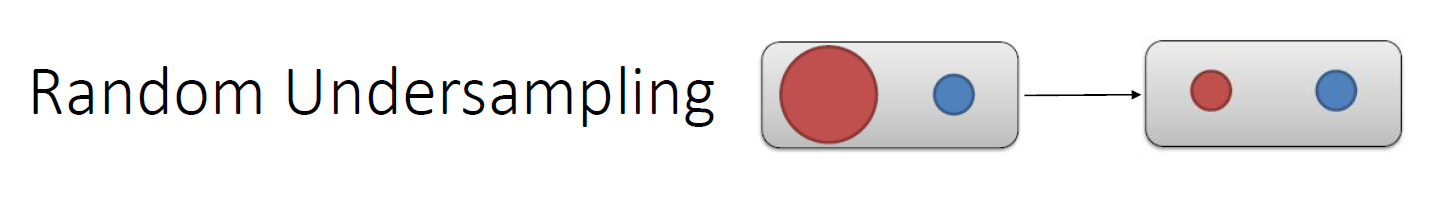

In [0]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)

ลองดูจำนวนของ data ที่ทำการ random undersampling จะเห็นว่าข้อมูลชุดที่ออกมาใช้ class 1 data(search_conduct)  and Red is class 0 (seach_conduct not occur) เท่ากัน เป็น balance data คือจำนวนที่ถูกตรวจค้นภายในรถเป็น 14193 คัน และ จำนวนที่ไม่ถูกตรวจค้นภายในรถเป็น 14193 คัน เท่ากันตาม code ที่แสดงข้างล่าง

In [0]:
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

y_train_subsample_unique, y_train_subsample_counts = np.unique(y_train_subsample, return_counts=True)
print(y_train_subsample_counts)

## Feature Scaling  


> ทำทั้งในชุด data ที่ imbalance และ balance แล้วเพื่อในตอนสุดท้ายจะนำมาเปรียบเทียบกัน

> การทำ Scaling ช่วยเพิ่มประสิทธิภาพให้กับการ train model ได้ การทำการ scaling ทำที่ขั้นตอนหลังจากแยกชุดข้อมูล ระหว่าง test และ train แล้วเพื่อป้องกันการรั่วของข้อมูล หรือ data leakage

> และเช่นเดิม ลอง print ค่าของ X_train, X_test ออกมาดู และ ขนาดของค่าต่างๆ ก็สำคัญ

In [0]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

X_train_subsample = sc.fit_transform(X_train_subsample)

> จะเห็นได้ว่า X_train_subsample ได้เท่ากับ จำนวนที่ทำ random undersampling ไว้แสดงว่าถูกต้อง

In [0]:
print(X_train.shape)
print(X_train_subsample.shape)
print(X_test.shape)

จากขนาดของข้อมูลแต่ละคู่ จะเห็นว่าจำนวน feature ยังเท่าเดิมคือ31 และจำนวน row ยังเท่าเดิมกับก่อนหน้าการทำ scaling ทั้งของ X_train, X_train_subsample และ X_test

In [0]:
# stop run all with print error
print(ttttt)

## Training model on Logistic Classification, SVC, random forrest, and  XGBOOST classification

Logistic Classification

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

scores = cross_validate(LogisticRegression(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_validate(undersample_pipe,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

SVC

In [0]:
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

scores = cross_validate(SVC(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline

undersample_pipe_svc = make_imb_pipeline(RandomUnderSampler(), SVC())
scores = cross_validate(undersample_pipe_svc,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC

undersample_pipe_svc = make_imb_pipeline(RandomUnderSampler(), SVC())

RandomForrest classification

In [0]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_validate(RandomForestClassifier(n_estimators=100),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
undersample_pipe_rf = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier(n_estimators=100))
scores = cross_validate(undersample_pipe_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

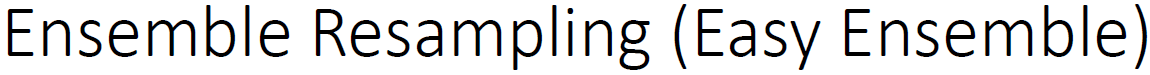

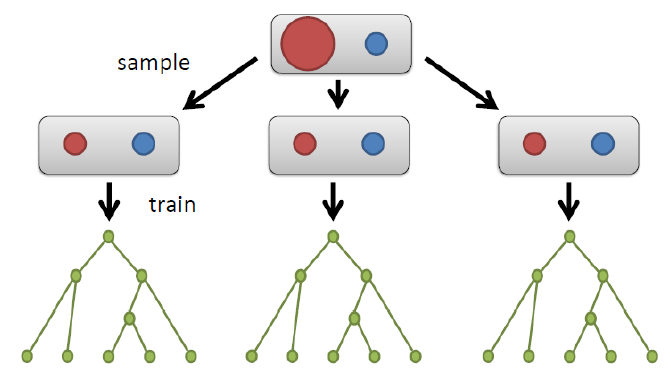

ลองวิธี Ensemble resampling  ด้วย BalanceBaggingClassifier
โดยลองด้วย Randomforest ตามด้วย logistic classifier model  แล้วเช็คดูค่า AUC and AP

In [0]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier

resampled_rf = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_features='auto'),
                                         random_state=0, n_estimators=100)

In [0]:
scores = cross_validate(resampled_rf,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
#scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
resampled_lr1 = BalancedBaggingClassifier(LogisticRegression(),
                                         n_estimators=100, random_state=0)

scores = cross_validate(resampled_lr1,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
resampled_svc = BalancedBaggingClassifier(SVC(),
                                         n_estimators=100, random_state=0)

scores = cross_validate(resampled_svc,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
resampled_svc = BalancedBaggingClassifier(SVC(),
                                         n_estimators=100, random_state=0)

ตอนนี้มีการวัดผลที่ได้ของทั้ง logistic classifier and random forrest ทั้งที่ทำ imbalance และ balance data ด้วยสองวิธี คือ RandomUndersampling และ Ensamble resampling เอามาเทียบกันด้วยการ plot ออกมาเป็น chart จะเห็นได้ชัดเจนกว่าในการเลือก model

เริ่มกันที่ Logistic ก่อน
ต่อด้วย SVC และต่อด้วย randomforrest และต่อด้วย XGBoost

In [0]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
lr = LogisticRegression().fit(X_train, y_train)
undersample_pipe.fit(X_train, y_train)
resampled_lr1.fit(X_train, y_train)

In [0]:
lr_crw = LogisticRegression(class_weight="balanced").fit(X_train, y_train)

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(lr, X_test, y_test, name="original", ax=axes[0])
# plot_roc_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[0])
plot_roc_curve(undersample_pipe, X_test, y_test, name="undersampling", ax=axes[0])
plot_roc_curve(resampled_lr1, X_test, y_test, name="balanced bagging", ax=axes[0])
plot_roc_curve(lr_crw, X_test, y_test, name="class re-weight", ax=axes[0])
axes[0].set_title("LogReg ROC curve")

plot_precision_recall_curve(lr, X_test, y_test, name="original", ax=axes[1])
# plot_precision_recall_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[1])
plot_precision_recall_curve(undersample_pipe, X_test, y_test, name="undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_lr1, X_test, y_test, name="balanced bagging", ax=axes[1])
plot_precision_recall_curve(lr_crw, X_test, y_test, name="class re-weight", ax=axes[1])
axes[1].set_title("LogReg PR curve")
plt.tight_layout()

SVC ROC curve and PR curve

In [0]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
svc = SVC().fit(X_train, y_train)
undersample_pipe_svc.fit(X_train, y_train)
# resampled_svc.fit(X_train, y_train)
svc_crw = SVC(class_weight="balanced").fit(X_train, y_train)

In [0]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(svc, X_test, y_test, name="original", ax=axes[0])
# plot_roc_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[0])
plot_roc_curve(undersample_pipe_svc, X_test, y_test, name="undersampling", ax=axes[0])
# plot_roc_curve(resampled_svc, X_test, y_test, name="balanced bagging", ax=axes[0])
plot_roc_curve(svc_crw, X_test, y_test, name="class re-weight", ax=axes[0])
axes[0].set_title("SVC ROC curve")

plot_precision_recall_curve(lr, X_test, y_test, name="original", ax=axes[1])
# plot_precision_recall_curve(oversample_pipe, X_test, y_test, name="oversampling", ax=axes[1])
plot_precision_recall_curve(undersample_pipe_svc, X_test, y_test, name="undersampling", ax=axes[1])
# plot_precision_recall_curve(resampled_svc, X_test, y_test, name="balanced bagging", ax=axes[1])
plot_precision_recall_curve(svc_crw, X_test, y_test, name="class re-weight", ax=axes[1])
axes[1].set_title("SVC PR curve")
plt.tight_layout()

In [0]:
rf = RandomForestClassifier(random_state=1).fit(X_train, y_train)
rf_crw = RandomForestClassifier(random_state=1, class_weight="balanced").fit(X_train, y_train)
undersample_pipe_rf.fit(X_train, y_train)
resampled_rf.fit(X_train, y_train)

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(rf, X_test, y_test, name="original", ax=axes[0])
plot_roc_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[0])
plot_roc_curve(resampled_rf, X_test, y_test, name="balanced bagging", ax=axes[0])
plot_roc_curve(rf_crw, X_test, y_test, name="class re-weight", ax=axes[0])
axes[0].set_title("RandomForest ROC curve")

plot_precision_recall_curve(rf, X_test, y_test, name="original", ax=axes[1])
plot_precision_recall_curve(undersample_pipe_rf, X_test, y_test, name="undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_rf, X_test, y_test, name="balanced bagging", ax=axes[1])
plot_precision_recall_curve(rf_crw, X_test, y_test, name="class re-weight", ax=axes[1])

axes[1].set_title("RandomForest PR curve")

#plt.tight_layout()
#plt.savefig("images/roc_vs_pr.png", dpi=500)

XGBOOST classification

In [0]:
from xgboost import XGBClassifier

scores = cross_validate(XGBClassifier(),
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
# scores = cross_validate(XGBClassifier(learning_rate =0.1,
#                   n_estimators=10,
#                   max_depth=4,
#                   min_child_weight=6,
#                   gamma=0,
#                   subsample=0.8,
#                   colsample_bytree=0.8,
#                   objective= 'binary:logistic',
#                   nthread=4,
#                   scale_pos_weight=1,
#                   seed=27),
#                         X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
undersample_pipe_xgb = make_imb_pipeline(RandomUnderSampler(), XGBClassifier())
scores = cross_validate(undersample_pipe_xgb,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
#break beforeXGB BalanceBaggingClassifier
print(ttttt)

ลองวิธี Ensemble resampling ด้วย BalanceBaggingClassifier โดยลองด้วย XGboost

In [0]:
resampled_xgb = BalancedBaggingClassifier(XGBClassifier(),
                                         n_estimators=100, random_state=0)

scores = cross_validate(resampled_xgb,
                        X_train, y_train, cv=10, scoring=('roc_auc', 'average_precision'))
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
scores['test_roc_auc'].mean(), scores['test_average_precision'].mean()

In [0]:
xgb_t = XGBClassifier(random_state=1).fit(X_train, y_train)
undersample_pipe_xgb.fit(X_train, y_train)
resampled_xgb.fit(X_train, y_train)

In [0]:
xgb_t = XGBClassifier(random_state=1).fit(X_train, y_train)
xgb_t_crw50 = XGBClassifier(random_state=1, scale_pos_weight=50).fit(X_train, y_train)
xgb_t_crw99 = XGBClassifier(random_state=1, scale_pos_weight=99).fit(X_train, y_train)

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_roc_curve(xgb_t, X_test, y_test, name="original", ax=axes[0])
plot_roc_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[0])
plot_roc_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[0])
plot_roc_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[0])
plot_roc_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[0])
axes[0].set_title("XGBclassifier ROC curve")

plot_precision_recall_curve(xgb_t, X_test, y_test, name="original", ax=axes[1])
plot_precision_recall_curve(undersample_pipe_xgb, X_test, y_test, name="undersampling", ax=axes[1])
plot_precision_recall_curve(resampled_xgb, X_test, y_test, name="balanced bagging", ax=axes[1])
plot_precision_recall_curve(xgb_t_crw50, X_test, y_test, name="class re-weight50", ax=axes[1])
plot_precision_recall_curve(xgb_t_crw99, X_test, y_test, name="class re-weight99", ax=axes[1])

axes[1].set_title("XGBclassifier PR curve")

#plt.tight_layout()
#plt.savefig("images/roc_vs_pr.png", dpi=500)

balance bagging ของ XGBclassifier ทำการ process เป็นเวลานานมาก ถือเป็น cost สูง จึงไม่เหมาะในการนำมาใช้

จาก model rf and xgb ดู มีแนวโน้มที่ดี ต้องลอง imbalance แบบอื่นเทียบ และใช้วิธี balanced bagging ซึ่งค่อนข้าง cost สูงจึงเลือก randomforrest เพื่อไป tune hyperparameter ต่อไป  
ส่วน XGB จะไปทำต่อโดยใช้ original data เนื่องจากอ้างอิงตาม xgb document แล้ว model ของ XGB มีการทำให้ data balance ด้วยค่า defualt อยู่แล้ว

Some go further and suggest that using a ROC curve with an imbalanced dataset might be deceptive and lead to incorrect interpretations of the model skill.  
The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets

## Note on Subset data use index selection

In [0]:
x = range(20)
list(x)

In [0]:
list(x[::2])


In [0]:
list(x[::3])


In [0]:
list(x[10:40:6])

### Making the Confusion Matrix for KNN

และวัดผลจากคะแนนต่างๆ เช่น accuracy score และ F1_score ของ KNN model

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score

y_pred = knnclf.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred)
print(cm_knn)
print("accuracy_score ของ model KNN :",accuracy_score(y_test, y_pred))
print("f1_score ของ model KNN :",f1_score(y_test, y_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['No','Yes'])
cmd.plot()

การใช้ KNN ใช้เวลาในการรัน train และเมื่อ train เสร็จ การ predict ก็ทำงานได้ช้ามากเมื่อขนาดของข้อมูลใหญ่มากแบบนี้ ประมาณ 1 ชั่วโมง

## Training the Logistic Regression model on the Training set

### ทำการ fit เพื่อ train model

In [0]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state=1)
classifier.fit(X_train, y_train)

## Predicting a new result on newdriver

### ลองใส่ชุดข้อมูลใหม่จากคนขับใหม่ที่ลองสร้างเองขึ้นมาครับว่า model ของเราใช้งานได้ และ ทำนายออกมาว่าจะโดนตรวจค้นยานพาหนะหรือไม่ และเมื่อสร้างข้อมูลขึ้นมาใหม่ จะต้องทำการ OneHotEncoder กับข้อมูลใหม่นี้ด้วยให้ตรงกับ shape ของการป้อนเข้าไปใส่ให้ model

In [0]:
# ให้ สมมตคนขับรถขึ้นมาหนึ่งคัน โดยมีข้อมูลดังนี้
newdriver = [['X4', 'white', 'female', True, False, False, False, False, False, 'Speeding']]
newdriver_encode = np.array(ct.transform(newdriver))

newdriver_encode

### ต้องทำการ scaling ก่อนเข้า model ด้วย

In [0]:
newdriver_scale = sc.transform(newdriver_encode)
print(newdriver_scale)
print(newdriver_scale.shape)

In [0]:
print(classifier.predict(newdriver_scale))

In [0]:
classifier.predict_proba(sc.transform(newdriver_scale))

In [0]:
classifier.predict_log_proba(sc.transform(newdriver_scale))

## Predicting the Test set results

### มาลองทดสอบวัดผลของ model โดยใช้ Test set ที่แยกไว้ตั้งแต่แรก ซึ่งเรามีผลลัพธ์ที่เกิดขึ้นจริงมาเปรียบเทียบกับโมเดล ทำให้เราสามารถวัดประสิทธิภาพความแม่นยำ ความเที่ยงตรง และค่าการวัดผลรูปแบบต่างๆ ได้จาก Test set นี้

In [0]:
classifier.predict(X_test)

In [0]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred), 1), y_test.reshape(len(y_test),1)), axis=1))
print(y_pred.shape)

ตัวแรกคือ predict และ ตัวที่สองคือค่าจริง ที่คนโดนตรวจค้นในรถหรือไม่โดน  
0 คือไม่โดน  
1 คือโดนตรวจค้นรถ

## Making the Confusion Matrix

ใช้ Confusion Matrix มาช่วยในการ evaluation

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
print("accuracy_score :", accuracy_score(y_test, y_pred))
print("roc_auc_score :", roc_auc_score(y_test, y_pred))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
cmd.plot()

##  Display classification performance metrics

หาค่าประสิทธิภาพอื่นๆของ classification model ของตัวนี้เพิ่มเติม

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Performance:")
print(" >accuracy = " + str(accuracy))
print(" >precision = " + str(precision))
print(" >recall = " + str(recall))
print(" >f1-score = " + str(f1))


## Visualising the ROC curve
เป็นการวัดประสิทธิภาพที่ดีตัวหนึ่งของ binary classification

ROC curve ของการตรวจค้นยานพาหนะ เป็นการนำเอา True Positive rate plot with False Positive Rate

In fact, any point on the blue line corresponds to a situation where True Positive Rate is equal to False Positive Rate.

 

All points above this line correspond to the situation where the proportion of correctly classified points belonging to the Positive class is greater than the proportion of incorrectly classified points belonging to the Negative class.

หมายความว่า ยิ่งเส้นสีส้มของเราห่างออกจากเส้นสีฟ้าไปข้างบนมากเท่าไหร่ก็แสดงว่า model ของเรา ทำการแยกแยะ ได้อย่างถูกต้องกว่า เช่น สมมติว่า มีของผิด กฏหมายในรถ ถ้าทำนายว่าโดนตรวจค้นแน่ๆ ก็จะกลัวก็อาจจะไม่ขับรถวันนี้ แต่ถ้า ทำนายว่าไม่โดนจับแน่แต่ทำนายผิด สุดท้ายแล้วเป็นความหวังที่คิดว่าไม่โดนตรวจค้น พอไปขับรถจริงโดนเรียกตรวจค้นก็เจอสิ่งผิดกฏหมายในรถ False Positive นั้นน่ากลัว ดังคำกล่าวของ <b>“False hopes are more dangerous than fears.”–J.R.R. Tolkein<b>

In [0]:
from sklearn.metrics import roc_curve

pred_prob = classifier.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue', label='Random prob')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('classification ROC',dpi=300);    

## Applying k-Fold Cross-Validation
เพื่อดูว่าการแบ่งชุดข้อมูลในการ train model ดีหรือไม่ โดยจะได้ออกมาเป็นค่าเฉลี่ยของ Accuracy

In [0]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

## Applying Grid Search to find the best model and the best parameters
ทำเพื่อหาค่า ปรับจูน hyperparameter ให้ได้ model ที่ดีที่สุด ใช้ code ดังนี้
และต้องการจะวัดค่าประสิทธิภาพของ model ด้วย ROC curve แทนการใช้ Accuracy จึ่งแทนค่า ที่ scoring = "roc_auc"

### จากการทำ Grid Search เพื่อปรับจูน hypermeter ที่เหมาะสมเพื่อการใช้งาน ทำให้ผลที่ออกมาถูกต้องแม่นยำและมีประสิทธิภาพมากยิ่งขึ่น โดย Hypermeter เหมาะสมที่ได้คือ
&#39;C&#39;
= &#39;0.001&#39; และ penalty = &#39;L2&#39;

In [0]:
from sklearn.model_selection import GridSearchCV
#np.logspace(-3,3,7) = array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])
# "penalty":["l1","l2"]}# l1 lasso l2 ridge

parameters = {'C': [0.0001, 0.0002, 0.0004, 0.0006, 0.0008, 0.001], 'penalty':['l1','l2','elasticnet']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 10,
                           n_jobs = -1)
grid_search.fit(X_train, y_train)
best_roc_auc = grid_search.best_score_
best_parameters = grid_search.best_params_
print("best_roc_auc: {:.2f} %".format(best_roc_auc*100))
print("Best Parameters:", best_parameters)

# ทำการ Training the Logistic Regression model ด้วย best parameter ที่ได้อีกครั้ง

In [0]:
from sklearn.linear_model import LogisticRegression
classifier2 = LogisticRegression(penalty= 'l2', C=0.001)
classifier2.fit(X_train, y_train)

##Make y_pred2 from new model and Making the Confusion Matrix
ใช้ Confusion Matrix มาช่วยในการ evaluation
จะเห็นว่ารูป Confusion Matrix และผลลัพธ์ที่ทำนาย y_pred2 เมื่อเทียบกับที่ทำนาย
y_pred ไว้ ผลออกมาเท่ากันเลย

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score

y_pred2 = classifier2.predict(X_test)

cm = confusion_matrix(y_test, y_pred2)
print(cm)
print("accuracy_score :", accuracy_score(y_test, y_pred2))
print("roc_auc_score :", roc_auc_score(y_test, y_pred2))
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No','Yes'])
cmd.plot()

## Visualizing the ROC curve

### หากดูเส้นกราฟนี้แล้วจะสามารถพิจารณาได้ว่าผลการทำนายของเรานั้นดีแค่ไหนโดยทั่วไปจะถือว่าหากกราฟยิ่ง ชิดด้านบนมากก็ยิ่งแปลว่าทำนายได้ดี แต่หากกราฟเป็นเส้นตรงจะแสดงว่าไม่ดี กราฟชิดด้านบนมากหมายความว่าพื้นที่ใต้กราฟมาก ค่าพื้นที่ใต้กราฟ ROC นี้ถูกเรียกว่า AUC (area under curve)

In [0]:
from sklearn.metrics import roc_curve

pred_prob2 = classifier2.predict_proba(X_test)

fpr12, tpr12, thresh12 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs2 = [0 for i in range(len(y_test))]
p_fpr2, p_tpr2, _ = roc_curve(y_test, random_probs2, pos_label=1)


# plot roc curves
plt.plot(fpr12, tpr12, linestyle='--',color='orange', label='Logistic Regression')
plt.plot(p_fpr2, p_tpr2, linestyle='--', color='blue', label='Random prob')

plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('classification ROC',dpi=300);   

ตัวโมเดล roc_auc ทำได้ดีที่สุดตาม best_parameters ที่ได้ปรับจูนแล้ว

# ประโยชน์จากจุดมุ่งหมายข้างบน และ finding ที่ได้จากข้อมูลการปฏิบัติหน้าที่ของตำรวจใน Rhode Island State

จากทั้งสองภาคที่ผ่านมา จะพบว่าคนขับที่เป็นคนผิวดำและคนเชื้อสายละตินนั้น
จะโดนใบสั่ง ถูกค้นตัว ถูกตรวจค้นยานพาหนะ
และนำไปสู่การจับกุมมากกว่าคนขับที่เป็นคนผิวขาว
ดังเช่นการเรียกตรวจจากการฝ่าฝืนความเร็วนั้น
คนขับที่เป็นคนผิวดำจะโดนเขียนใบสั่งมากกว่า 20% ของคนผิวขาว
และเป็นคนขับเชื้อสายละตินก็จะโดนเขียนใบสั่งมากกว่า 30 %
ของคนผิวขาวในข้อหาฝ่าฝืนความเร็ว
และเป็นเช่นเดียวกัน การตรวจค้นตัวและตรวจค้นยานพาหนะ ทั้งนี้
จากการวิเคราะห์เพื่อหาคำตอบว่า
การตรวจค้นที่เกิดขึ้นนั้นเกิดจากความมีพิรุธขนาดไหน
และพื้นฐานก็ความน่าสงสัยเกี่ยวโยงกับ
เชื้อชาติและลักษณะของคนขับอย่างไรได้บ้าง
คำตอบก็คือ คนผิวดำ จะโดนตรวจค้นตัวและยานพาหนะ ด้วยความอคติ โดยที่
baseline ความน่าสงสัยและหลักฐานอ้างอิงอันน้อยนิดเมื่อเทียบกับคนผิวขาวทั่วไป
ส่วนอัตราการตรวจค้นจากเชื้อชาติที่มีอิทธิพลในการอคติทำให้อัตราการค้นพ้นสิ่งผิ
ดกฏหมายก็มากขึ้นด้วย
ซึ่งไม่ได้หมายความว่าสิ่งที่ผิดกฏหมายจะอยู่กับคนผิวดำเป็นอัตราส่วนมากกว่า
เพียงแต่ว่าอัตราการตรวจค้นที่กระทำต่อคนผิวขาวนั้นน้อยกว่า จากตรงนี้
ข้อมูลทำให้เราเห็นได้ชัดเจนว่า
สองมาตรฐานในการปฏิบัติงานของตำรวจนั้นมีอยู่จริง

## จากจุดมุ่งหมายของ classification model นี้

### 1.ถ้านำไปใช้ที่ผิดศีลธรรม ทำให้ผู้ที่ต้องการกระทำผิดกฎหมายสามารถเลือกใช้ Transporter ตามประเภท, ลักษณะ, เชื้อชาติ, เพศแบบไหนที่จะสามารถหลีกเลี่ยงการจับกุม หลีกเลี่ยงการถูกตรวจค้น หรือแม้กระทั่งหลีกเลียงการฝ่าฝืนกฏจราจรให้ได้มากที่สุด เพื่อลดความเสี่ยงที่จะทำให้เกิดการถูกตรวจค้นหรือโดนค้นหาสิ่งผิดกฎหมายในยานพาหนะในที่สุุด

### 2.นำไปใช้เพื่อให้เกิดประโยชน์ และเพิ่มประสิทธิภาพการทำงานของตำรวจ ทำให้ตำรวจไม่เกิด Bias หรืออคติต่อกลุ่มบุคคลใดกลุ่มบุคคลหนึ่งมากเกินไป และไม่ปล่อยปะละเลยกับอีกกลุ่มบุคคลหนึ่ง ปฏิบัติอย่างเท่าเทียมกันต่อทุกๆคน โดยไม่คำนึงถึงเชื้อชาติ เพศ อายุุ ทำให้ภาพลักษณ์ในการปฏิบัติหน้าที่ของตำรวจมีความยุติธรรม โปร่งใสและรอบคอบมากยิ่งขึ้น ซึ่งอาจจะทำให้ได้รับความร่วมมือจากประชาชนเป็นอย่างดีในการสืบสวน สอบสวน หรือการให้ข้อมูลที่เป็นประโยชน์กับตำรวจในการปฏิบัติหน้าที่ต่อไป